# Apply corrections to hits
### JAH 3/10/18

<i>
This notebook applies corrections to h-dsts to produce an energy spectrum

</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Oct 19 22:29:04 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number             = 6348
tag                    = "trigger2_v0.9.9_20180921_th" 
input_hdst_filenames        = [f"$IC_DATA/{run_number}/hdsts_bin1/hdst_0000_{run_number}_{tag}.h5"]
# bootstrap correction
run_number_correction      = run_number
correction_filename        = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"


### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   invisible_cities.io.hits_io          import load_hits
from   invisible_cities.io.dst_io           import load_dst
from   invisible_cities.core.core_functions import in_range

import krcal.utils.hst_extend_functions   as hst
import krcal.dev.corrections              as corrections

import csth.utils.hpeak_tables                 as hptab
import csth.utils.hpeak_hdsts_functions        as hphdst
import csth.utils.hpeak_plot_functions         as hpplot

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### init calibration

In [6]:
input_hst_filenames = [os.path.expandvars(fi) for fi in input_hdst_filenames]
correction_filename = os.path.expandvars(correction_filename)
calibrate = corrections.Calibration(correction_filename, 'scale')

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/kr_corrections_run6348.h5
node             : scale
Energy   scale : 10194.4 (pes)
Lifetime scale : 4751.3 (us) 
Charge   scale : 603.6 (pes)


### load hits

In [7]:
print(input_hst_filenames)

['/Users/hernando/investigacion/NEXT/data/runIV//6348/hdsts_bin1/hdst_0000_6348_trigger2_v0.9.9_20180921_th.h5']


In [8]:
hits = load_hits(input_hst_filenames[0])

In [9]:
hits.keys()

dict_keys([5, 9, 47, 160, 178, 188, 192, 213, 217, 220, 261, 271, 273, 274, 275, 305, 363, 366])

In [10]:
hits[5].hits[0]

<Hit : npeak = 0 z = 269.825 XYpeak = 113.30584651774375, -16.020750282824846 E = 2.777531147003174 cluster =< nsipm = 0 Q = -999999.0
                    xy = xy(x=0.0, y=0.0) 3dHit = Hit(0.0, 0.0, 269.825, E=2.777531147003174)  > >

In [11]:
hits = load_dst(input_hst_filenames[0],'RECO','Events')

### show hits as DF

In [12]:
hits[hits.event == 160]

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E
106,160,1.538212e+09,0,-31.857881,60.09923,0,0.000000,0.000000,0.000000,0.000000,126.318375,-999999.000000,58.348137
107,160,1.538212e+09,0,-31.857881,60.09923,0,0.000000,0.000000,0.000000,0.000000,127.210750,-999999.000000,1262.536621
108,160,1.538212e+09,0,-31.857881,60.09923,9,-35.366954,67.957324,6.962551,6.727856,128.139000,278.404633,5465.518066
109,160,1.538212e+09,0,-31.857881,60.09923,9,-35.308077,67.275938,6.598828,6.845498,129.090750,613.630249,14534.050781
110,160,1.538212e+09,0,-31.857881,60.09923,9,-35.387058,67.314763,6.902051,6.917746,130.062938,915.671204,22857.568359
111,160,1.538212e+09,0,-31.857881,60.09923,9,-35.535622,67.631803,6.964723,6.840957,131.022562,950.145569,21850.503906
112,160,1.538212e+09,0,-31.857881,60.09923,6,-35.024467,87.187926,7.228704,4.134276,131.022562,95.736969,2201.663818
113,160,1.538212e+09,0,-31.857881,60.09923,9,-35.168641,67.415690,6.957230,6.764837,131.996563,743.504761,17887.869141
114,160,1.538212e+09,0,-31.857881,60.09923,9,-34.730760,66.889472,7.013786,7.044802,132.977750,390.016083,9873.624023
115,160,1.538212e+09,0,-31.857881,60.09923,9,-34.662207,67.117852,6.741507,7.178606,133.993687,142.301620,4994.309570


In [13]:
events = np.unique(hits.event.values)
print(events)

[  5   9  47 160 178 188 192 213 217 220 261 271 273 274 275 305 363 366]


In [14]:
elist = hphdst.event_list(hits)
print(elist.event)
print(elist.peak)

[  5   9  47 160 178 188 192 213 217 220 261 271 273 274 275 305 363 366]
[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1]


In [15]:
etab = hphdst.event_table(elist, hits)

In [16]:
stab = hphdst.slice_table(etab, hits)

In [17]:
htab = hphdst.hit_table(etab, hits)

In [18]:
htab = hphdst.calibrate_hits(htab, calibrate)

In [19]:
etab, stab, htab = hphdst.update_tables(etab, stab, htab)

In [20]:
edf = hptab.df_from_table(etab, hptab.etable_names)
#edf

In [21]:
sdf = hptab.df_from_table(stab, hptab.stable_names)
#sdf

In [22]:
hdf = hptab.df_from_table(htab, hptab.htable_names)
#hdf

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


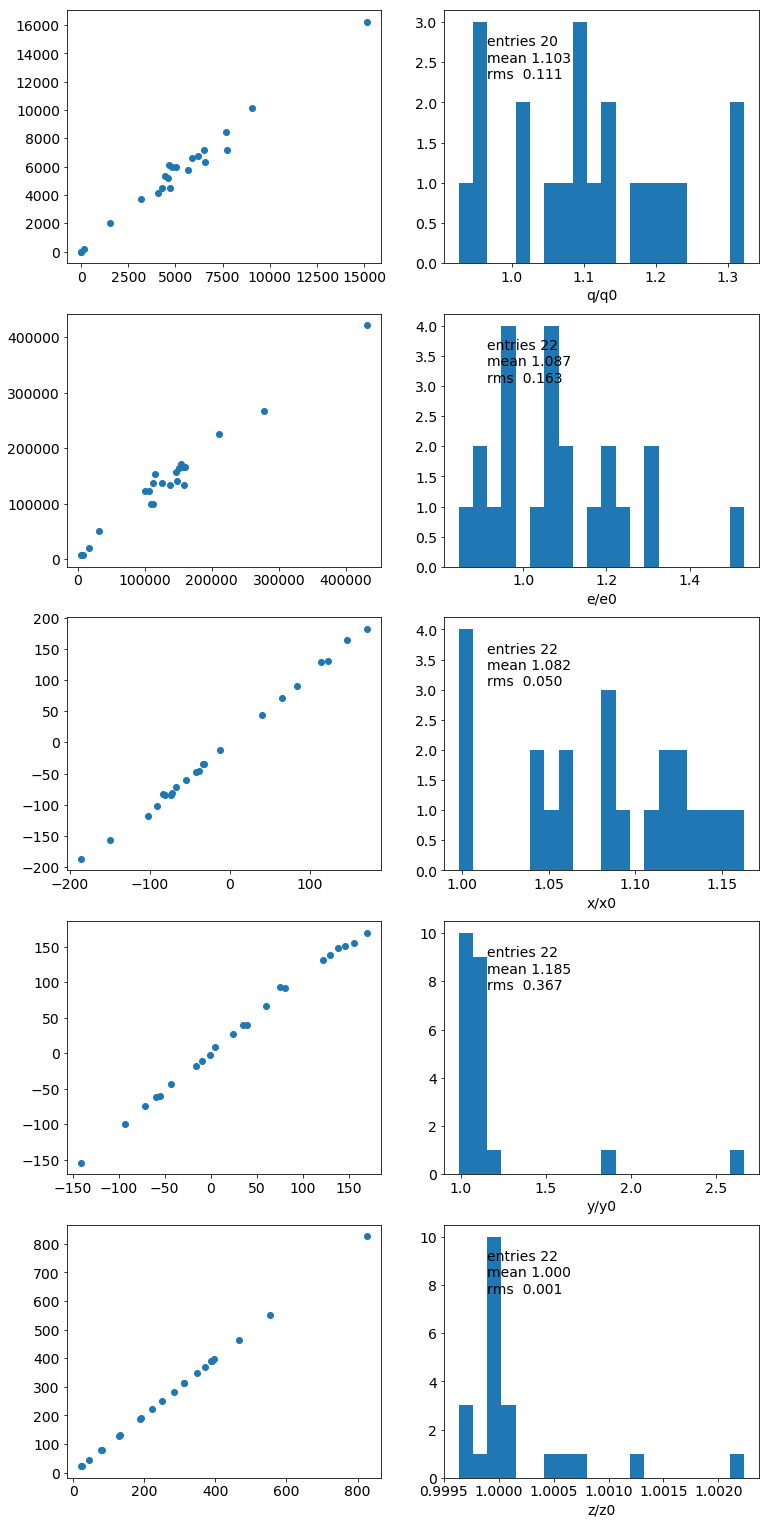

In [23]:
hpplot.plot_ratio(edf, [('q0', 'q'), ('e0', 'e'), ('x0', 'x'), ('y0', 'y'), ('z0', 'z')], 20)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


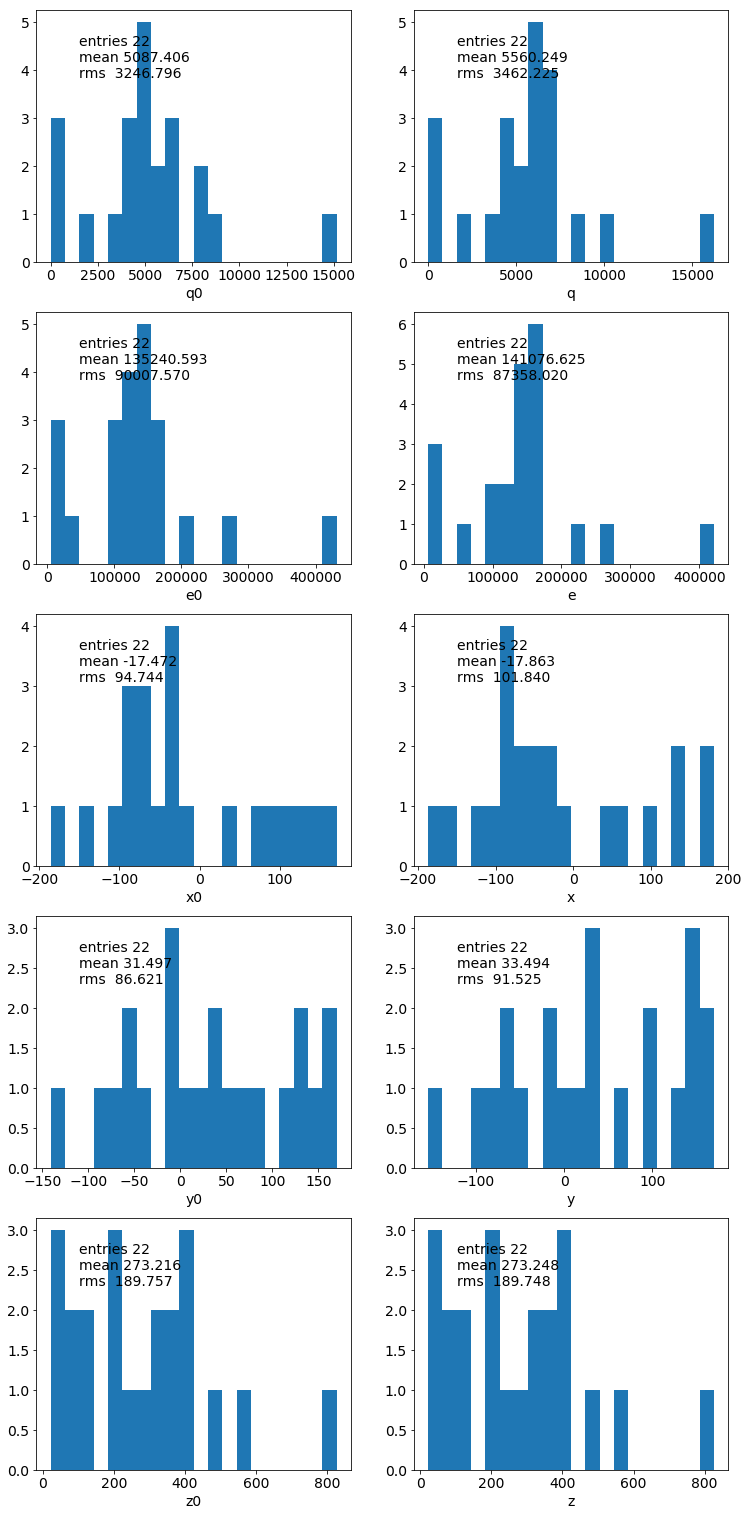

In [24]:
hpplot.plot_var(edf, ['q0', 'q', 'e0', 'e', 'x0', 'x', 'y0', 'y', 'z0', 'z'], 20)

In [25]:
print(etab.event)

[  5   9  47 160 178 188 188 192 213 217 220 261 271 273 273 273 274 275
 305 305 363 366]


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


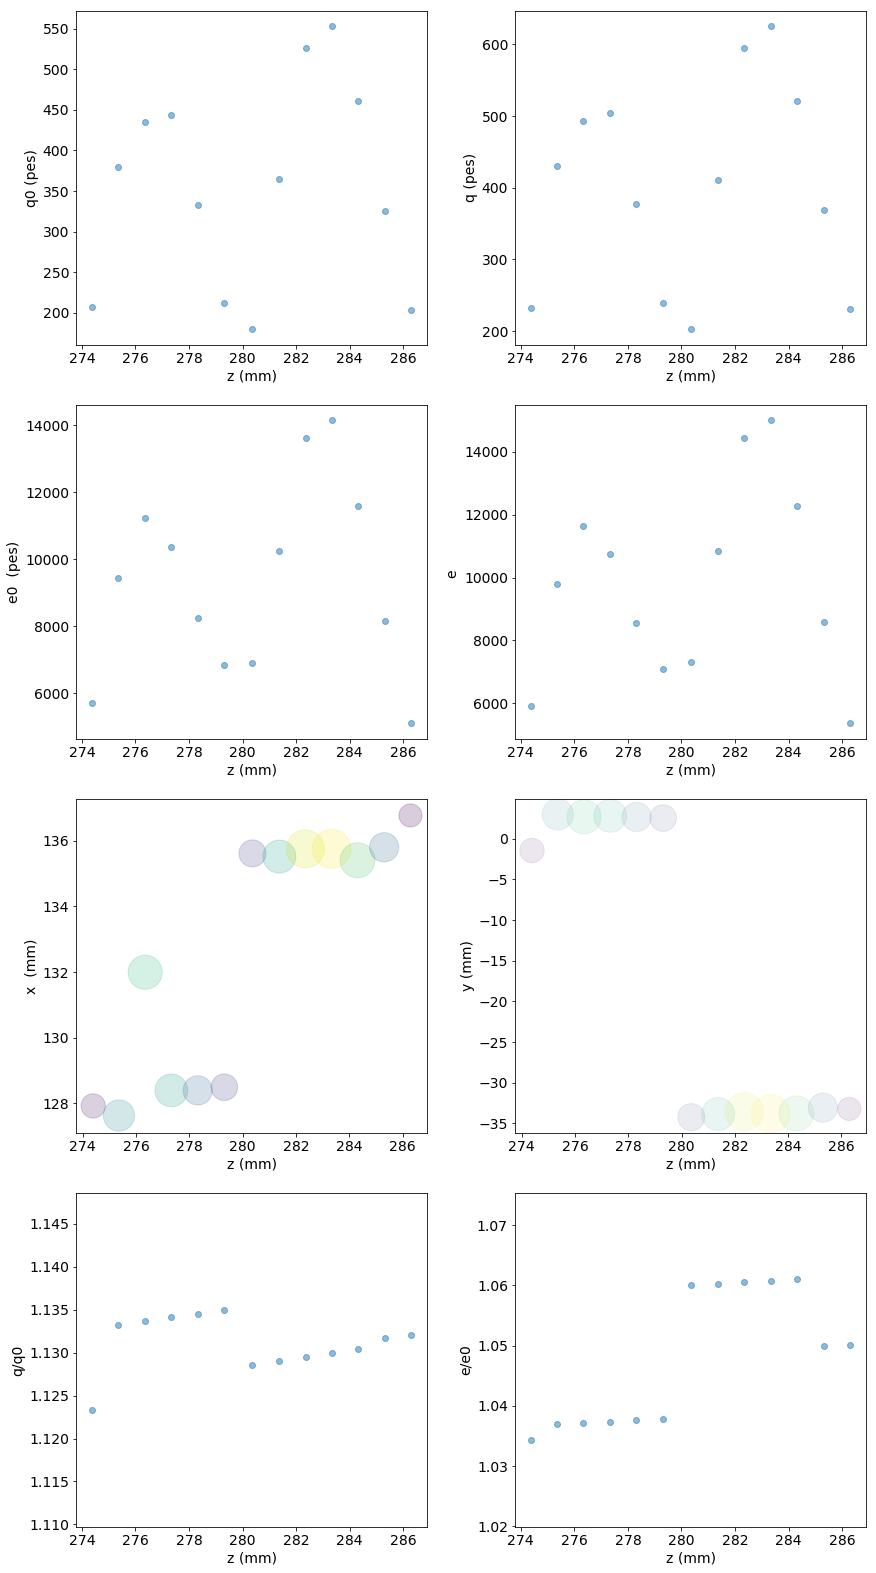

In [26]:
ievt = 5
hpplot.plot_vs_z(hdf[hdf.event==ievt])

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


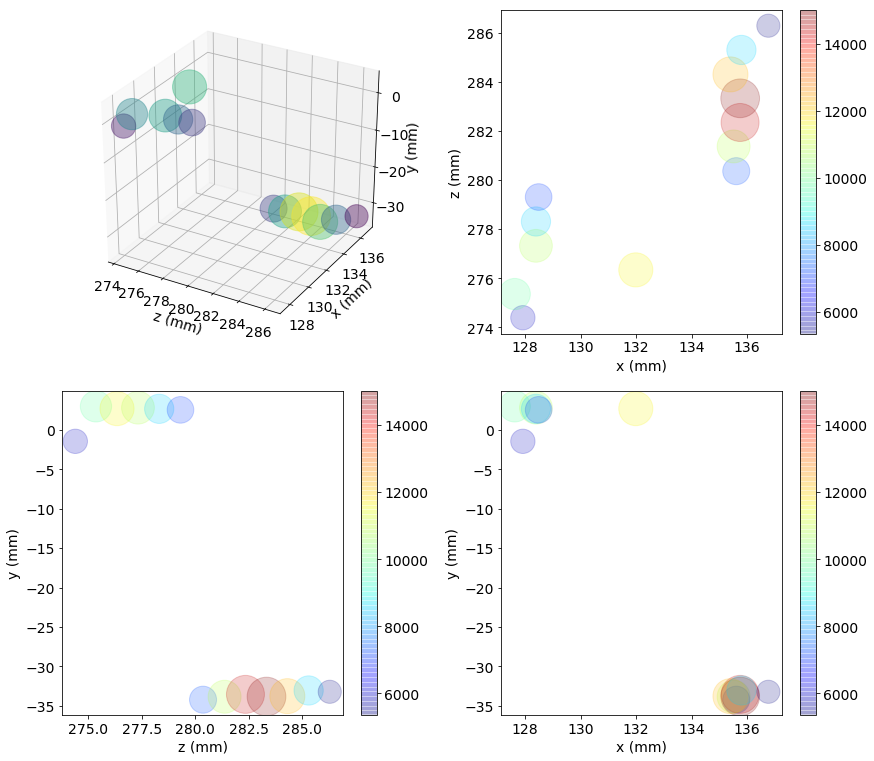

In [27]:
hpplot.graph_hits(hdf[hdf.event == ievt])

### In one go

In [28]:
edf, sdf, hdf = hphdst.hpeaks_dfs(hits, calibrate)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


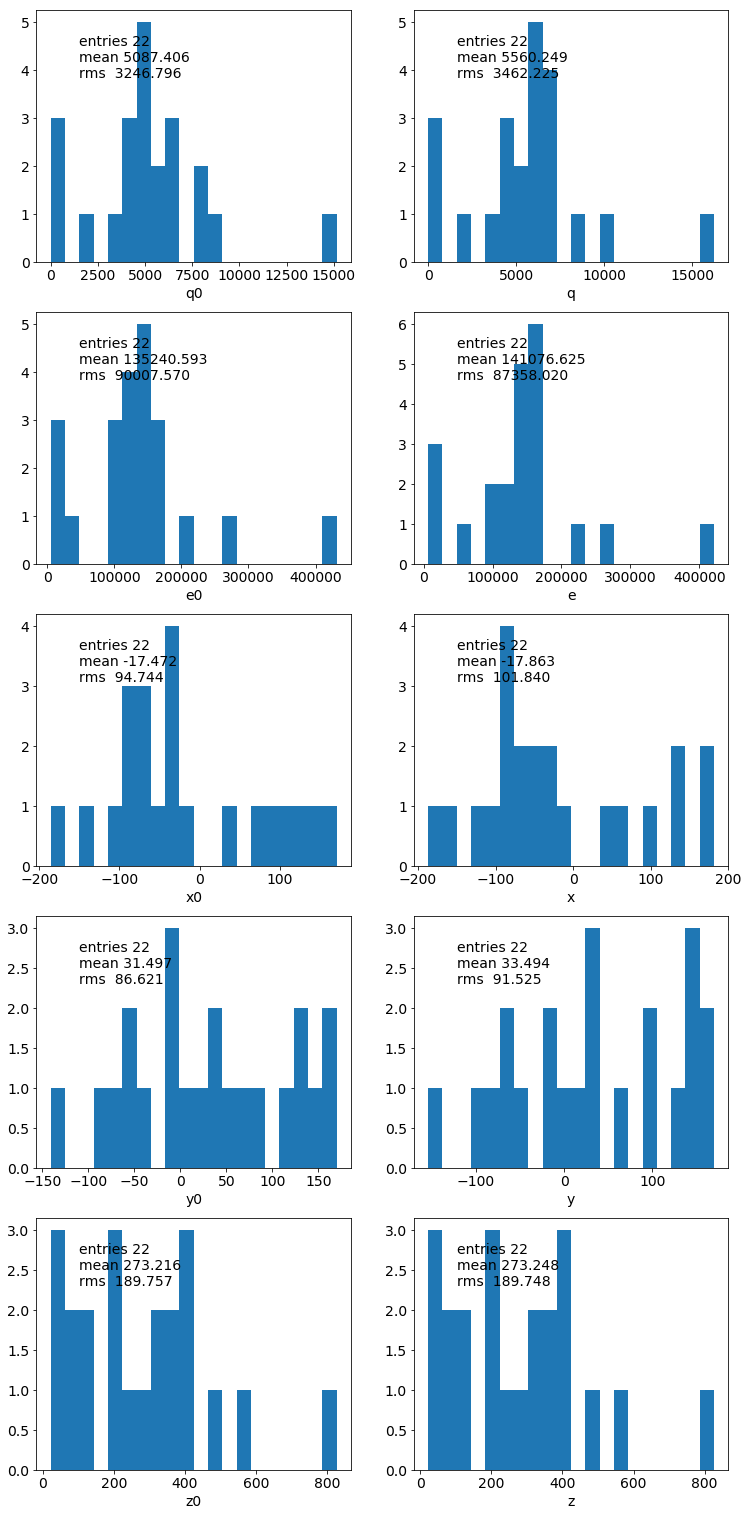

In [29]:
hpplot.plot_var(edf, ['q0', 'q', 'e0', 'e', 'x0', 'x', 'y0', 'y', 'z0', 'z'], 20)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


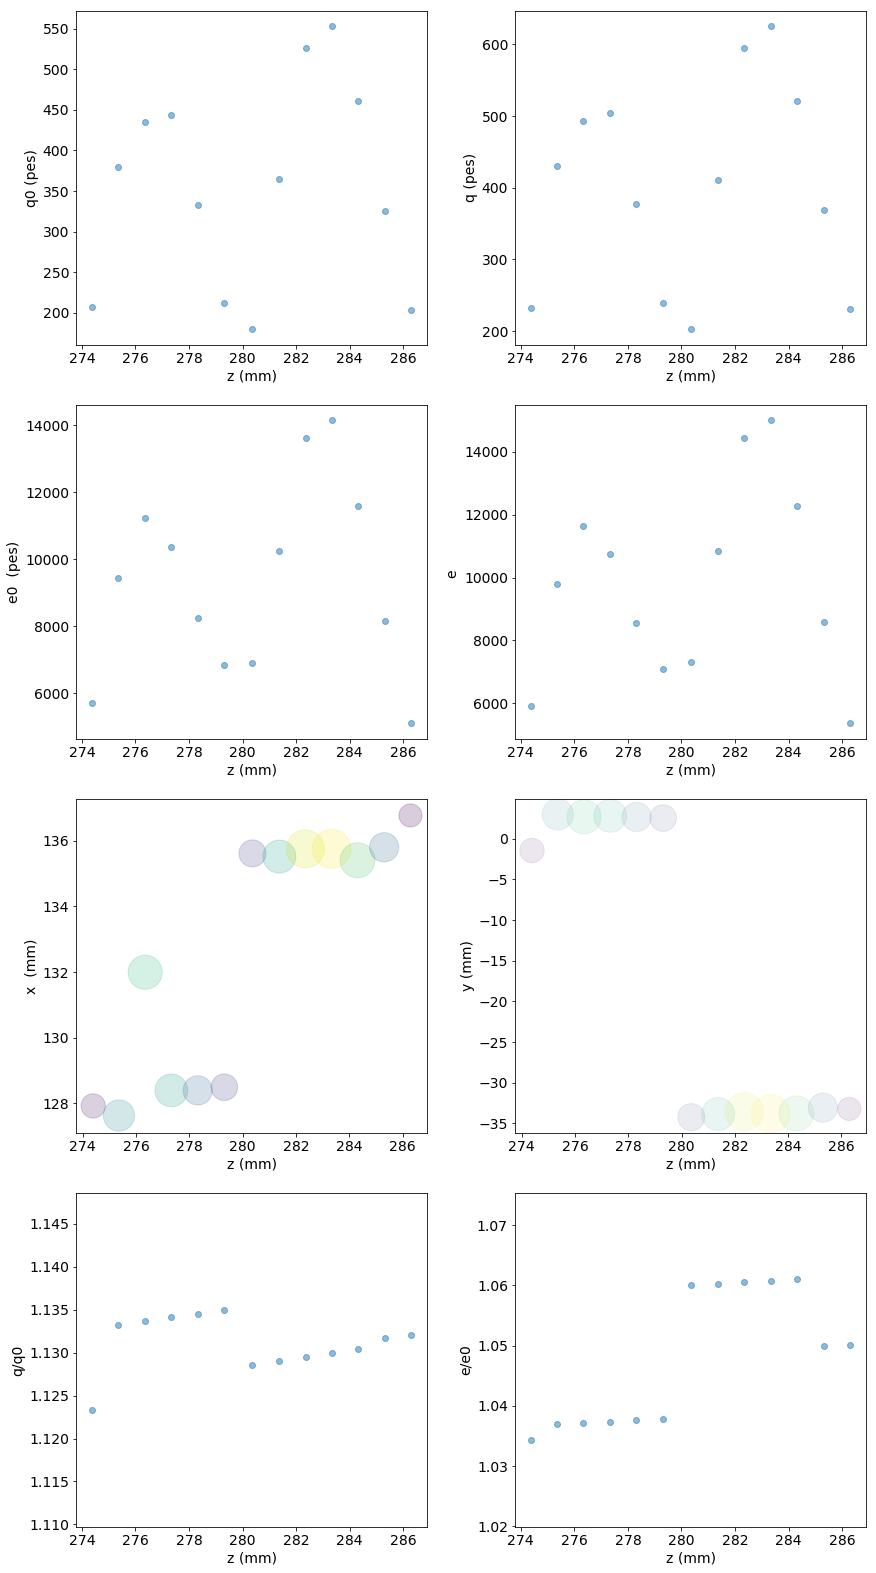

In [30]:
ievt = 5
hpplot.plot_vs_z(hdf[hdf.event == ievt])

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


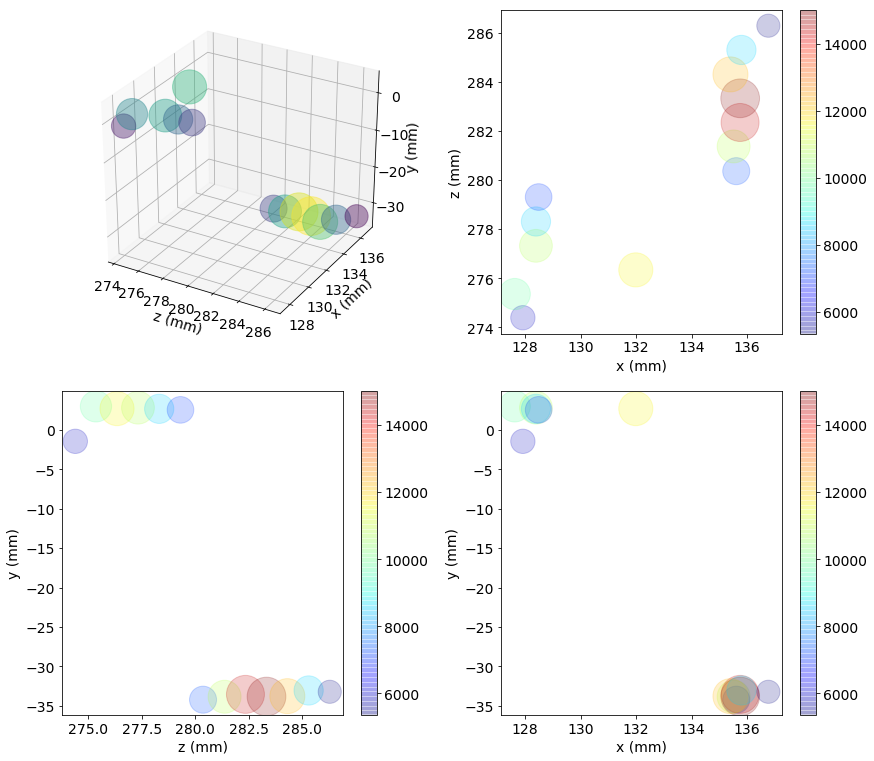

In [31]:
hpplot.graph_hits(hdf[hdf.event == ievt])